# <font size="12"><font color='red'>EKE vs ATMOS obs rain </font> </font> 
## <font size=30> Pearson correlation

In [1]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import matplotlib.colors as colors
import intake
import dask
from scipy.spatial import cKDTree
import networkx as nx
import psyplot.project as psy
import pandas as pd
from scipy.stats import pearsonr
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.stats
from scipy import stats

dask.config.set({"array.slicing.split_large_chunks": True}) 

# <font size="12"><font color='b'>DATA access </font> </font> 

In [2]:
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
eerie_cat["dkrz.disk.model-output.icon-esm-er.eerie-control-1950.atmos.gr025"]

gr025:
  args:
    path: https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/dkrz/disk/model-output/icon-esm-er/eerie-control-1950/atmos/gr025/main.yaml
  description: This catalog contains atmospheric EERIE ICON-ESM-ER eerie-control-1950
    output on 0.25deg grid available at DKRZ disk.
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/dkrz/disk/model-output/icon-esm-er/eerie-control-1950/atmos


In [3]:
eerie_dkrz=eerie_cat["dkrz"]

In [4]:
eerie_dkrz_disk=eerie_dkrz["disk"]
#for col in eerie_dkrz_disk:
#    print(f"Description of {col}:")
#    print(eerie_dkrz_disk[col].describe()["description"])

In [5]:
cat=eerie_dkrz_disk["model-output"]["icon-esm-er"]

In [6]:
searchdict=dict(
    model="ICON",
    realm="atmos",
    exp="eerie-control-1950",
    var="pr",
    frequency="daily"
)
subcat=cat
for v in searchdict.values():
    subcat=subcat.search(v)
list(subcat)

['eerie-control-1950.atmos.gr025.2d_daily_max',
 'eerie-control-1950.atmos.gr025.2d_daily_mean',
 'eerie-control-1950.atmos.gr025.2d_daily_min',
 'eerie-control-1950.atmos.gr025.plev19_daily_mean',
 'eerie-control-1950.atmos.native.2d_daily_max',
 'eerie-control-1950.atmos.native.2d_daily_mean',
 'eerie-control-1950.atmos.native.2d_daily_min',
 'eerie-control-1950.atmos.native.model-level_daily_mean_1',
 'eerie-control-1950.atmos.native.model-level_daily_mean_2',
 'eerie-control-1950.atmos.native.plev19_daily_mean']

In [7]:
#EKE
ds=cat["eerie-control-1950.ocean.gr025.2d_daily_mean"].to_dask()
ds

<xarray.Dataset>
Dimensions:                              (time: 13695, lat: 721, lon: 1440,
                                          lev: 1, depth: 1)
Coordinates:
  * depth                                (depth) float64 1.0
  * lat                                  (lat) float64 -90.0 -89.75 ... 90.0
  * lev                                  (lev) float64 0.0
  * lon                                  (lon) float64 0.0 0.25 ... 359.5 359.8
  * time                                 (time) datetime64[ns] 2002-01-01T23:...
Data variables: (12/30)
    Wind_Speed_10m                       (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Evaporation    (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Precipitation  (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Runoff         (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_SnowFall       (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_HeatFlux_Latent         (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    ...                                   ...
    so                                   (time, depth, lat, lon) float32 dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    ssh                                  (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    stretch_c                            (time, lat, lon) float32 dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    to                                   (time, depth, lat, lon) float32 dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    u                                    (time, depth, lat, lon) float32 dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    v                                    (time, depth, lat, lon) float32 dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
Attributes: (12/31)
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    CDO:                       Climate Data Operators version 2.2.2 (https://...
    Conventions:               CF-1.6
    DOKU_License:              CC BY 4.0
    DOKU_Name:                 EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:              Putrasahan, D.; Kröger, J.; Wachsmann, F.
    ...                        ...
    simulation_id:             erc1011
    source:                    git@gitlab.dkrz.de:icon/icon-mpim.git@45022778...
    source_id:                 ICON-ESM
    source_type:               AOGCM
    time_reduction:            mean
    title:                     ICON simulation

# <font size="5"><font color='b'>save to local machine to compute over night </font> </font> 

##  <font size="12"><font color='red'>EKE data </font> </font> 

# <font size="5"><font color='b'>Take the first 365 days </font> </font> 

In [ ]:
ds.u[:365,0,:,:]

# <font size="5"><font color='b'>compute eke at different resolutions (step) </font> </font> 

In [ ]:
ds.u[:365,0,:,:]

In [13]:
#NOT RESIZED (for the nice little plots underneath)
#make the mean

u_mean_tot=np.mean(ds.u[:365,0,::1,::1], axis=0) #mean across axis=0, ovvero il tempo
v_mean_tot=np.mean(ds.v[:365,0,::1,::1], axis=0)

#calculate eddy velocities
u_eddy_tot=(ds.u[:365,0,::1,::1].values)-(u_mean_tot[:,:].values)
v_eddy_tot=(ds.v[:365,0,::1,::1].values)-(v_mean_tot[:,:].values)

#calculate eke
eke_tot=(((u_eddy_tot)**2)+((v_eddy_tot)**2))/2

In [14]:

#make the mean
step=10
u_mean=np.mean(ds.u[:365,0,::step,::step], axis=0) #mean across axis=0, ovvero il tempo
v_mean=np.mean(ds.v[:365,0,::step,::step], axis=0)

#calculate eddy velocities
u_eddy=(ds.u[:365,0,::step,::step].values)-(u_mean[:,:].values)
v_eddy=(ds.v[:365,0,::step,::step].values)-(v_mean[:,:].values)

#calculate eke
eke_s=(((u_eddy)**2)+((v_eddy)**2))/2

# <font size="5"><font color='b'>Plot EKE </font> </font> 

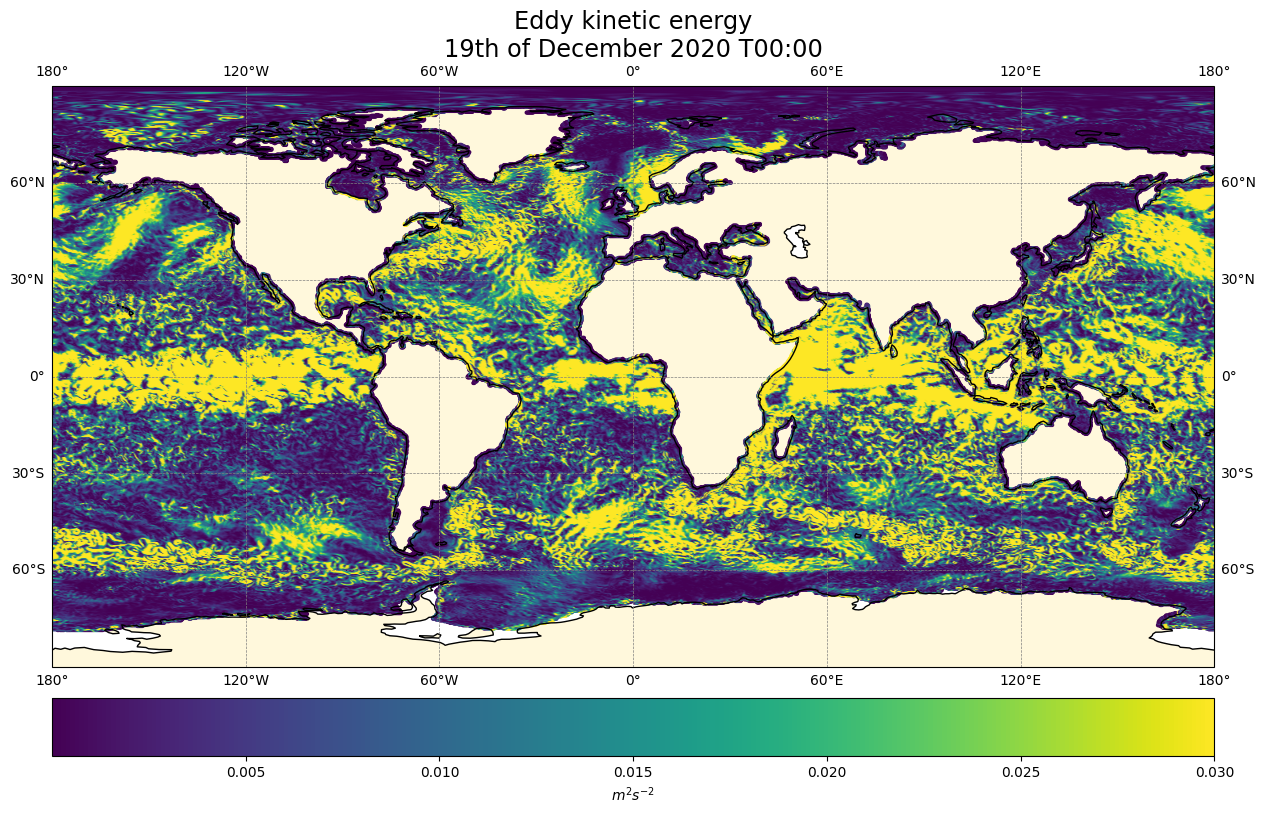

In [15]:

lon_mesh, lat_mesh = np.meshgrid(ds.lon[::1], ds.lat[::1])

# sstep controls the spacing between points to plot
sstep=1

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
ax = plt.axes(projection= ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')

# Fill the continents with a color
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.set_title('Eddy kinetic energy'+'\n'+'19th of December 2020 T00:00', size='xx-large')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

sc=ax.scatter(lon_mesh,lat_mesh,  c=eke_tot[0,:,:], s=4 ,cmap='viridis',
              transform=ccrs.PlateCarree(), vmax=0.03)#,vmin=np.min(cut_eke[np.nonzero(cut_eke)]),              vmax=0.05)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label(r'$m^{2} s^{-2}$')


# PLOT ATM data

In [26]:
atm=cat['eerie-control-1950.atmos.gr025.2d_daily_mean'].to_dask()

In [29]:
atm['time']

<xarray.DataArray 'time' (time: 10651)>
array(['2002-01-01T23:59:00.000000000', '2002-01-02T23:59:00.000000000',
       '2002-01-03T23:59:00.000000000', ..., '2031-02-26T23:59:00.000000000',
       '2031-02-27T23:59:00.000000000', '2031-02-28T23:59:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01T23:59:00 ... 2031-02-28T23:59:00
Attributes:
    axis:           T
    standard_name:  time

In [ ]:
np.nanmin(frshflux_s[0,:,:])

In [35]:
pr=atm['pr'][:365,:,:].values
#np.save('atmfrshflux2002.npy', frshflux)
pr_s=atm['pr'][:365,::step,::step].values
pr.shape

(365, 721, 1440)

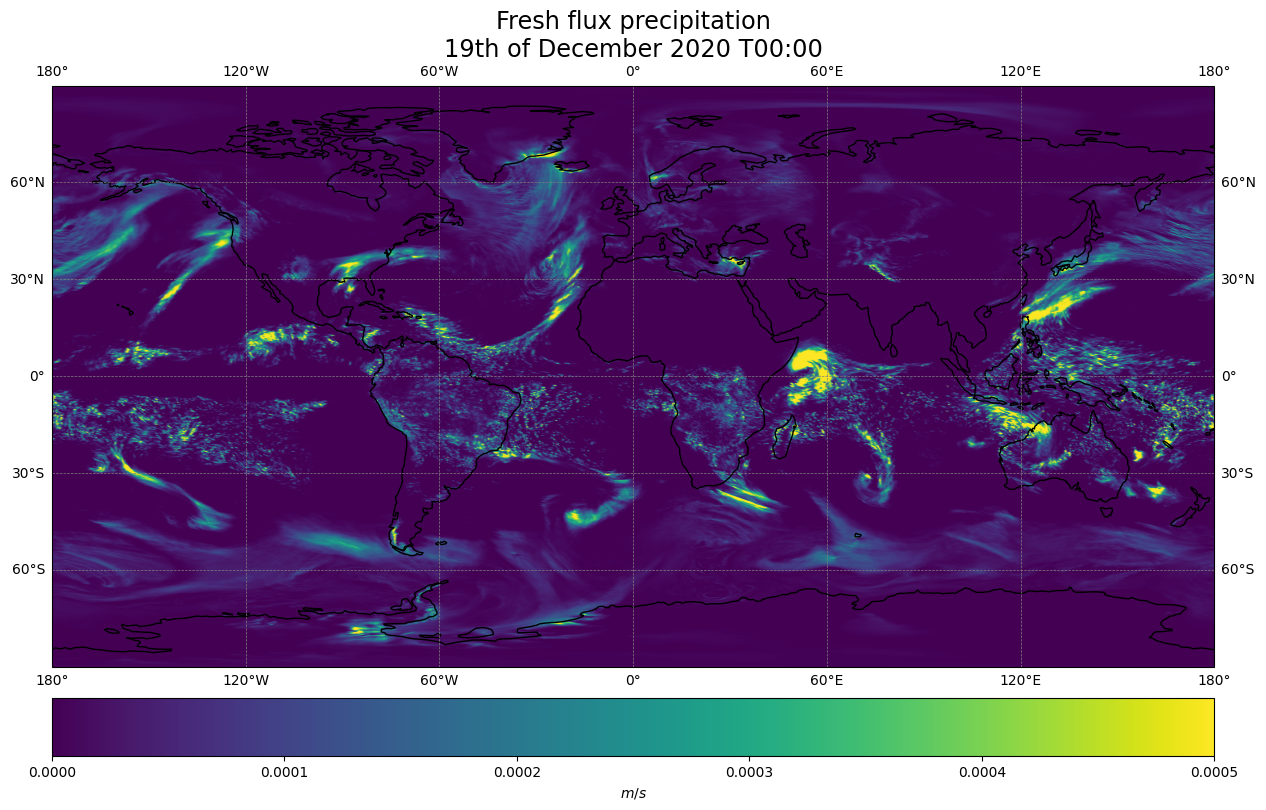

In [45]:

lon_mesh, lat_mesh = np.meshgrid(ds.lon[::1], ds.lat[::1])

# sstep controls the spacing between points to plot
sstep=1

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
ax = plt.axes(projection= ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')

# Fill the continents with a color
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.set_title('Fresh flux precipitation'+'\n'+'19th of December 2020 T00:00', size='xx-large')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

sc=ax.scatter(lon_mesh,lat_mesh,  c=pr[0,:,:], s=4 ,cmap='viridis',
              transform=ccrs.PlateCarree(), vmin=np.nanmin(pr[0,:,:]),vmax=0.0005)#,vmin=np.min(cut_eke[np.nonzero(cut_eke)]),              vmax=0.05)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label(r'$m/s$')

##  <font size="15"><font color='b'>NETWORK creation-------------------------</font> </font> 


# <font size="5"><font color='b'>you need to run pearson correlation index between eke2002 and atmfrshflux2002 time series, if they are correlated create an undirected edge
for directed edges: need granger causality index </font> </font> 

In [ ]:
#eke=np.load('eke2002.npy')

In [ ]:
#frshflux=np.load('atmfrshflux2002.npy')

## NETWORK CREATION

In [46]:
#PROVA2


latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = eke_s
frshflux_downsized = pr_s

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape

# Create a graph
G = nx.Graph()

# Set the correlation threshold
correlation_threshold = 0.5

# Iterate over all positions (lat, lon) for 'eke'
for lat in range(num_latitudes):
    for lon in range(num_longitudes):
        if not np.any(np.isnan(eke_downsized[:, lat, lon])):
            # Extract time series at the current 'eke' position
            time_series_eke = eke_downsized[:, lat, lon]

            # Iterate over all positions (lat, lon) for 'frshflux'
            for lat_frshflux in range(num_latitudes):
                for lon_frshflux in range(num_longitudes):
                    if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                        # Extract time series at the current 'frshflux' position
                        time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]


                        # Check for NaN values
                        if not (np.any(np.isnan(time_series_eke)) or np.any(np.isnan(time_series_frshflux))):
                            # Calculate Pearson correlation coefficient
                            correlation, _ = pearsonr(time_series_eke, time_series_frshflux)

                            # Check if correlation is above the threshold
                            if abs(correlation) > correlation_threshold:
                                # Add nodes to the graph
                                node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                                node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                                G.add_node(node_eke)
                                G.add_node(node_frshflux)

                                # Add weighted edge with correlation coefficient as weight
                                G.add_weighted_edges_from([(node_eke, node_frshflux, correlation)])


#SAVE:

# Convert node tuples to strings before saving
G_str_labels = nx.relabel_nodes(G, {node: str(node) for node in G.nodes()})

# Save the graph to a GraphML file
nx.write_graphml(G_str_labels, "eke_atmrain_correlation_graph_2002_step10.graphml")

In [8]:
#TO RE-LOAD
# Read the graph from the GraphML file
G_loaded = nx.read_graphml("correlation_graph_2002_step10.graphml")

# Convert node strings back to tuples---> THIS IS THE NETWORK
G = nx.relabel_nodes(G_loaded, {node: eval(node) for node in G_loaded.nodes()})

# Now G_original_labels should have nodes represented as tuples
#pos = {node: (node[1], node[0]) for node in G_original_labels.nodes()}



In [ ]:
pos = {node: (node[1], node[0]) for node in G.nodes()} # No need to modify longitudes, assuming they are already in the range -180 to +180
node[2]

# PLOT

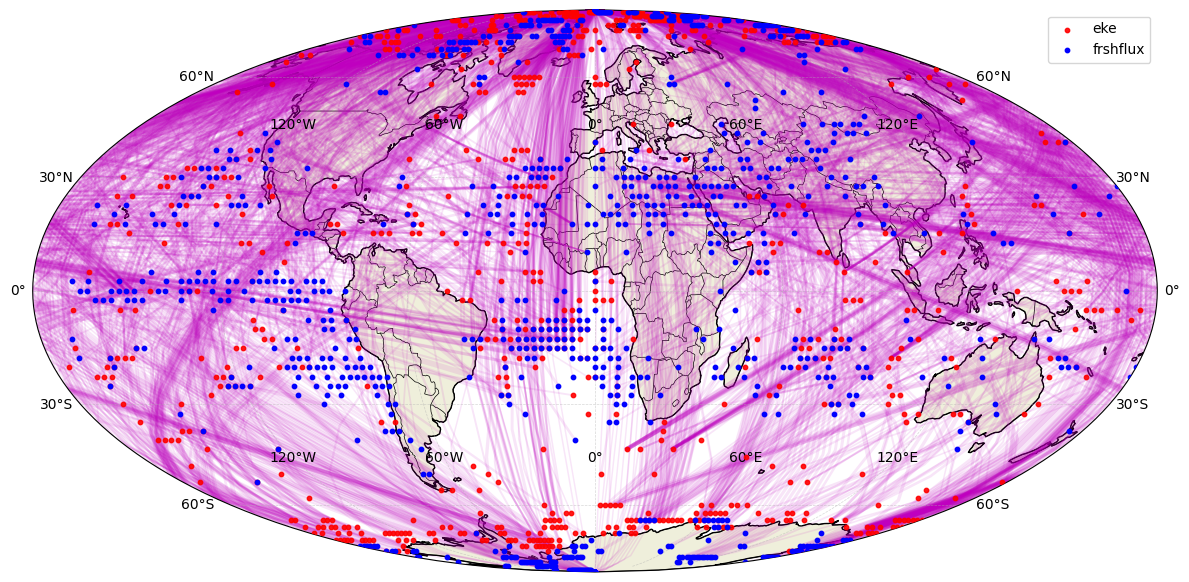

In [49]:
# 

# Generate layout for visualization with Cartopy (changes to long,lat)
pos = {node: (np.mod(node[1], 360), node[0]) for node in G.nodes()} # No need to modify longitudes, assuming they are already in the range -180 to +180

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.Mollweide()})
# ax.set_global()
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0.5, draw_labels=True)

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in G.nodes() if node[2] == 'eke']
frshflux_nodes = [node for node in G.nodes() if node[2] == 'frshflux']

#PARTE VECCHIA======================================================================
#for edge, weight in zip(G.edges(), edge_weights):
#    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))  # Normalize weights between 0 and 1
#    edge_width = 1 + 4 * normalized_weight  # Adjust the multiplier for the desired range of edge widths
#    ax.plot([pos[edge[0]][0], pos[edge[1]][0]],
#            [pos[edge[0]][1], pos[edge[1]][1]], 
#            alpha=0.1, color="m", linewidth=edge_width)

# Plot nodes
#ax.scatter([pos[node][0] for node in eke_nodes], [np.mod(pos[node][1],180) for node in eke_nodes], s=10, color="red", alpha=0.9, label='eke',zorder=20001)
#ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes], s=10, color="blue", alpha=1, label='frshflux',zorder=20001)
#======================================================================



#QUI CONTROLLA CHE COSA SUCCEDE ALLE LOGNITUDINI E LATITUDINI============================================
for edge, weight in zip(G.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    #print("prima",pos[edge[0]][1], pos[edge[1]][1])
    lon1 = (np.mod(pos[edge[0]][1], 180))
    lon2 = (pos[edge[1]][1])

    
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [lon1, lon2], alpha=0.1, color="m", linewidth=edge_width, transform=ccrs.PlateCarree())

# Plot nodes
ax.scatter([pos[node][0] for node in eke_nodes], [pos[node][1] for node in eke_nodes], 
           s=10, color="red", alpha=0.9, label='eke', zorder=20001, transform=ccrs.PlateCarree())
ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes],
           s=10, color="blue", alpha=1, label='frshflux', zorder=20001, transform=ccrs.PlateCarree())
#======================================================================






ax.legend()

# Change font color for legend
#font["color"] = "r"


# Resize figure for label readability
ax.margins(0.1, 0.05)
#fig.savefig()
fig.tight_layout()
plt.show()


## INTERACTIVE GRAPH

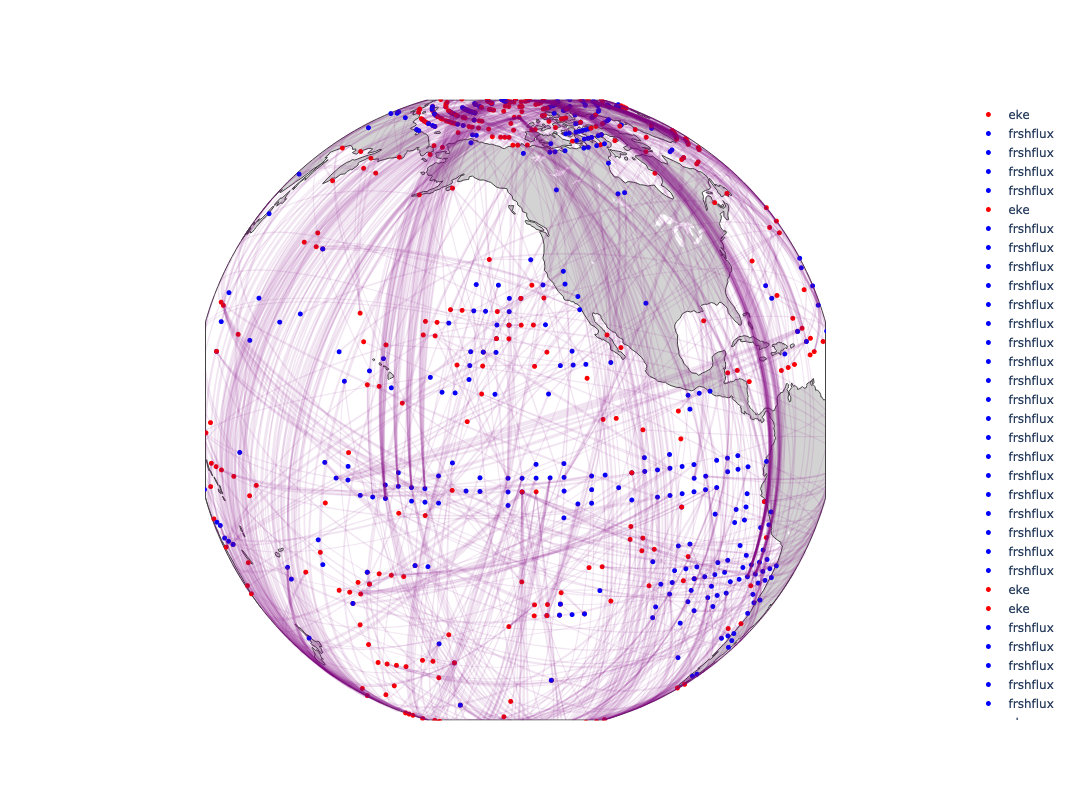

In [79]:
import plotly.graph_objects as go

# Assuming you have a graph G
# G = ...

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in G.nodes() if node[2] == 'eke']
frshflux_nodes = [node for node in G.nodes() if node[2] == 'frshflux']

# Create a Plotly graph object
fig = go.Figure()

# Plot nodes
for node in G.nodes():
    fig.add_trace(go.Scattergeo(
        lon=[pos[node][0]],
        lat=[pos[node][1]],
        mode='markers',
        marker=dict(
            size=5,
            color="red" if node[2] == 'eke' else "blue",
        ),
        name=node[2],  # Use the node type as the legend label
        #legendgroup=node[2]  # Assign the same legendgroup to traces with the same label
    ))

# Plot edges
for edge, weight in zip(G.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    fig.add_trace(go.Scattergeo(
        lon=[pos[edge[0]][0], pos[edge[1]][0], None],  # None to create a gap between segments
        lat=[pos[edge[0]][1], pos[edge[1]][1], None],
        mode='lines',
        line=dict(
            width=edge_width,
            color='rgba(128, 0, 128, 0.1)',
        ),
        text=f'Correlation: {weight}',
        hoverinfo='text',
        #legendgroup=node[2]  # Assign the same legendgroup to traces with the same label
    ))
    



# Update layout for better visibility
fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="#D3D3D3",  # Set the color for the land
        projection_type="orthographic"
    ),
    width=1000,  # Set the width of the plot
    height=800   # Set the height of the plot
)


# Save the plot as an HTML file
#fig.write_html("EKEvsRAIN_2002_step10.html")


## Node Degree map

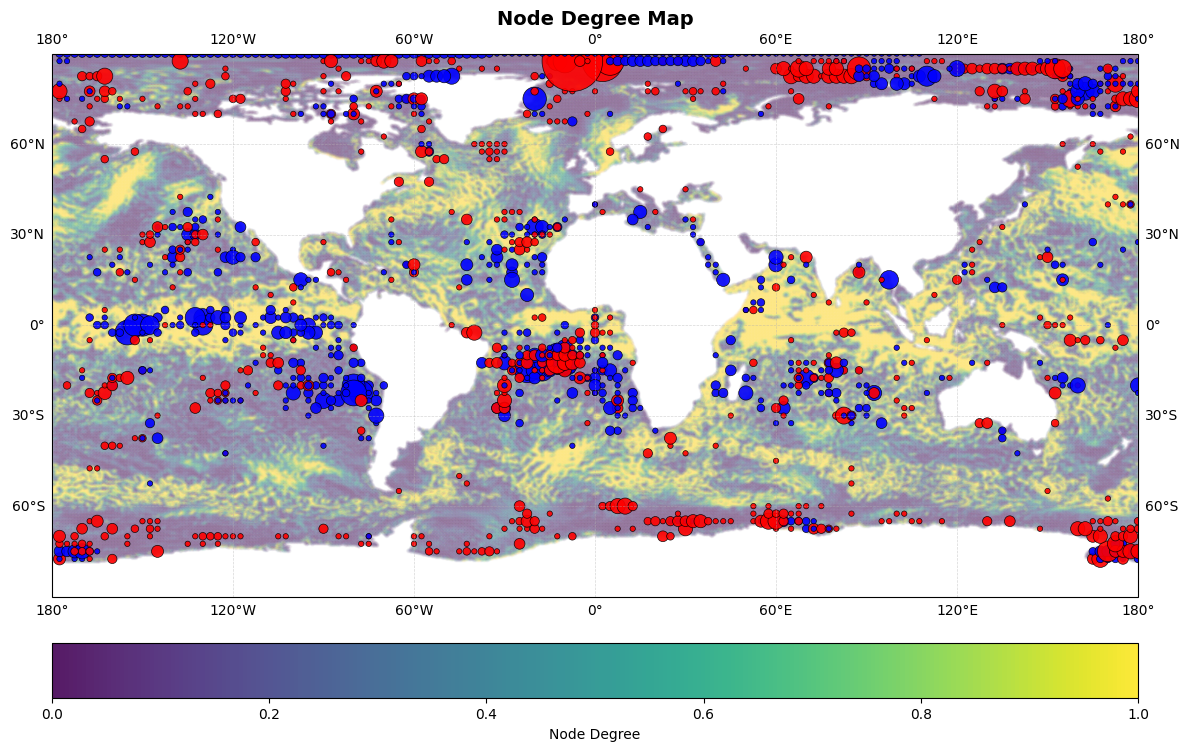

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx

# Assuming you have a graph G
# G = ...

# Generate layout for visualization with Cartopy
pos = {node: (node[1], node[0]) for node in G.nodes()}  # Convert longitudes to the range -180 to +180

# Calculate node degrees
degrees = dict(G.degree())

# Extract node positions, sizes, and colors based on node type
node_positions = np.array([pos[node] for node in G.nodes()])
node_sizes = np.array([degrees[node] for node in G.nodes()])
node_colors = ['red' if node[2] == 'eke' else 'blue' for node in G.nodes()]

# Create a scatter plot with node sizes proportional to degree and colors based on type
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')




#EKE underneath=============================================================================================
lon_mesh, lat_mesh = np.meshgrid(ds.lon[::1], ds.lat[::1])

sb=ax.scatter(lon_mesh,lat_mesh,  c=eke_tot[0,:,:], s=4 ,cmap='viridis',
              transform=ccrs.PlateCarree(), vmax=0.03,alpha=0.02)   

#============================================================================================

# Scatter plot nodes
sc = ax.scatter(node_positions[:, 0], node_positions[:, 1], s=node_sizes*15, c=node_colors, alpha=0.9, edgecolors='k', linewidths=0.5)



#for edge, weight in zip(G.edges(), edge_weights):
 #   normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))  # Normalize weights between 0 and 1
 #   edge_width = 1 + 4 * normalized_weight  # Adjust the multiplier for the desired range of edge widths
 #   ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [pos[edge[0]][1], pos[edge[1]][1]], 
 #   alpha=0.1, color="m", linewidth=edge_width)
# Plot edges
#for edge, weight in zip(G.edges(), edge_weights):
 #   ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [pos[edge[0]][1], pos[edge[1]][1]], alpha=1, color="m", linewidth=weight)




# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.04)
cbar.set_label('Node Degree')

# Add world map and gridlines
#ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0.5, draw_labels=True)

# Title
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Node Degree Map", font)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.show()
